## Project Setup

In [21]:
# Libraries
import os
import ta
import time
import json
import openai
import pandas as pd
import numpy as np
import vectorbt as vbt
from pathlib import Path
import coinbasepro as cbp
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from IPython.display import Image, display


#Settings
import warnings
warnings.filterwarnings("ignore")

#OpenAI API key
credentials = json.loads(Path('../credentials.json').read_text())['openai']
openai.api_key = credentials.get('api_key')

#Current working directory
print(f'Current working directory: {os.getcwd()}')

Current working directory: /workspaces/Summerschool_FS2024/Trading_Bot


## Data Collection

In [31]:

# Load API credentials from the JSON file
with open('../credentials.json') as f:
    credentials = json.load(f)


API_KEY = credentials['sandbox']['api_key']
API_SECRET = credentials['sandbox']['secret']
API_PASSPHRASE = credentials['sandbox']['passphrase']

# Connect to the Coinbase Pro Sandbox
auth_client = cbpro.AuthenticatedClient(API_KEY, API_SECRET, API_PASSPHRASE, api_url='https://api-public.sandbox.pro.coinbase.com')

#Public client
client = cbp.PublicClient()

#Function to Get Data
def get_data(symbol,start, stop, granularity):

#Server Request
    data = client.get_product_historic_rates(product_id=symbol,
                                         start=start,
                                         stop=stop,
                                         granularity=granularity)

# Store data in a data frame
    df = pd.DataFrame(data, columns=['time',
                                 'low',
                                 'high',
                                 'open',
                                 'close',
                                 'volume'])
    df['Date'] = pd.to_datetime(df['time'], unit='s')     
    df = df.set_index('Date')
    df.drop('time', inplace=True, axis=1)
    df = df.sort_values('Date', ascending=True)
    df.columns = df.columns.str.capitalize()

#Change data types for calculations
    df['Low'] = df['Low'].astype(float)
    df['High'] = df['High'].astype(float)
    df['Open'] = df['Open'].astype(float)
    df['Close'] = df['Close'].astype(float)
    df['Volume'] = df['Volume'].astype(float)

    return df

# Parameters for the data retrieval
symbol = 'BTC-USD'
end_time = datetime.now()
start_time = end_time - timedelta(days=10)  # Retrieve data for the last 24 hours
granularity = 3600  # 1 hour granularity

# Retrieve the data
df = get_data(symbol, start_time.isoformat(), end_time.isoformat(), granularity)

# Print the DataFrame
print(df)


                          Low      High      Open     Close       Volume
Date                                                                    
2024-06-25 13:00:00  60968.20  61400.18  61011.91  61169.76   803.943675
2024-06-25 14:00:00  61118.28  62130.84  61169.77  61736.47  1929.214988
2024-06-25 15:00:00  61309.41  61947.12  61736.47  61797.50  1295.941794
2024-06-25 16:00:00  61336.74  61926.78  61797.50  61369.59  1148.887801
2024-06-25 17:00:00  61306.39  61772.19  61356.59  61374.30   565.887573
...                       ...       ...       ...       ...          ...
2024-07-05 08:00:00  54047.02  54441.15  54381.56  54079.37   464.727009
2024-07-05 09:00:00  53883.89  54717.58  54076.07  54514.51   554.206128
2024-07-05 10:00:00  54384.00  55342.75  54513.27  54974.56   694.523333
2024-07-05 11:00:00  54976.43  55642.37  54977.77  55474.79  1075.106088
2024-07-05 12:00:00  54992.00  56025.00  55474.79  55272.07  1437.127850

[240 rows x 5 columns]


## Define the strategy A: Short/Long MA

In [32]:
# Define the trading strategy: Moving Average Crossover
def apply_moving_average_strategy(df, short_window=40, long_window=100):
    # Calculate the short and long moving averages
    df['Short_MA'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
    df['Long_MA'] = df['Close'].rolling(window=long_window, min_periods=1).mean()

    # Generate trading signals
    df['Signal'] = 0  # Default to no signal
    df['Signal'][short_window:] = np.where(df['Short_MA'][short_window:] > df['Long_MA'][short_window:], 1, 0)
    df['Position'] = df['Signal'].diff()  # Buy signal (1) or sell signal (-1)

    return df


## Apply the strategy

                          Low      High      Open     Close       Volume   
Date                                                                       
2024-07-05 08:00:00  54047.02  54441.15  54381.56  54079.37   464.727009  \
2024-07-05 09:00:00  53883.89  54717.58  54076.07  54514.51   554.206128   
2024-07-05 10:00:00  54384.00  55342.75  54513.27  54974.56   694.523333   
2024-07-05 11:00:00  54976.43  55642.37  54977.77  55474.79  1075.106088   
2024-07-05 12:00:00  54992.00  56025.00  55474.79  55272.07  1437.127850   

                       Short_MA     Long_MA  Signal  Position  
Date                                                           
2024-07-05 08:00:00  57861.5420  60422.8407       0       0.0  
2024-07-05 09:00:00  57716.7650  60334.4079       0       0.0  
2024-07-05 10:00:00  57586.6910  60250.7601       0       0.0  
2024-07-05 11:00:00  57483.7905  60173.3381       0       0.0  
2024-07-05 12:00:00  57376.9940  60097.5866       0       0.0  


ValueError: x and y must be the same size

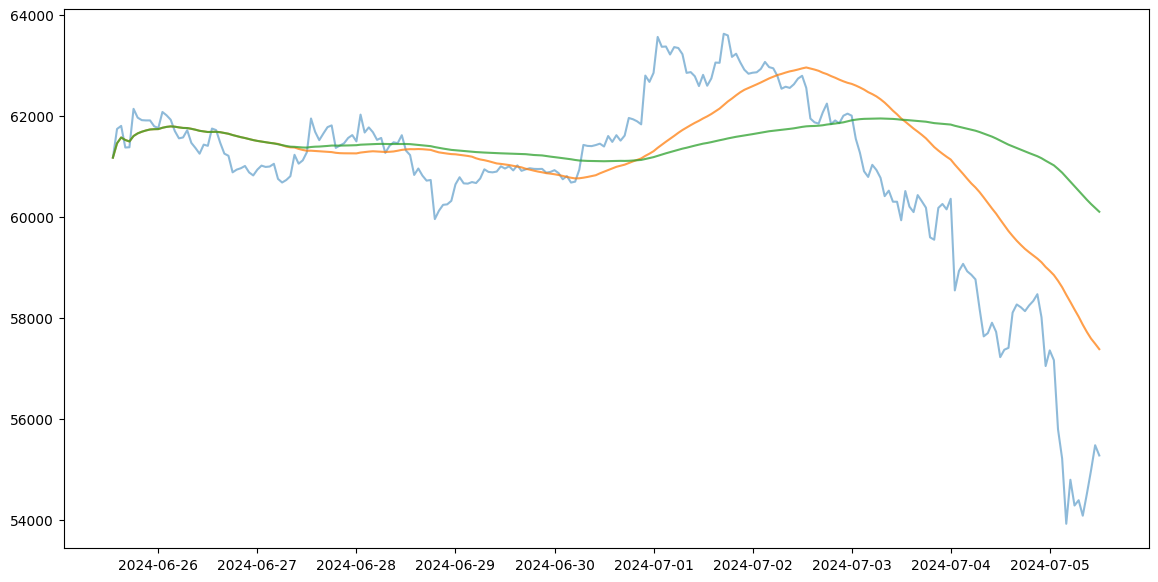

In [34]:
# Apply the strategy to the data
df = apply_moving_average_strategy(df)

# Display the DataFrame with signals
print(df.tail())

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price', alpha=0.5)
plt.plot(df['Short_MA'], label='Short MA', alpha=0.75)
plt.plot(df['Long_MA'], label='Long MA', alpha=0.75)
plt.scatter(df.index, df[df['Position'] == 1]['Close'], label='Buy Signal', marker='^', color='green', lw=3)
plt.scatter(df.index, df[df['Position'] == -1]['Close'], label='Sell Signal', marker='v', color='red', lw=3)
plt.title('BTC-USD Price with Buy and Sell Signals')
plt.legend()
plt.show()

## 

## Strategy B: MACD + RSI as signals

                          Low      High      Open     Close       Volume   
Date                                                                       
2024-07-05 08:00:00  54047.02  54441.15  54381.56  54079.37   464.727009  \
2024-07-05 09:00:00  53883.89  54717.58  54076.07  54514.51   554.206128   
2024-07-05 10:00:00  54384.00  55342.75  54513.27  54974.56   694.523333   
2024-07-05 11:00:00  54976.43  55642.37  54977.77  55474.79  1075.106088   
2024-07-05 12:00:00  54992.00  56025.00  55474.79  55272.07  1437.127850   

                       Short_MA     Long_MA  Signal  Position         MACD   
Date                                                                         
2024-07-05 08:00:00  57861.5420  60422.8407       0       0.0 -1219.331631  \
2024-07-05 09:00:00  57716.7650  60334.4079       0       0.0 -1209.062817   
2024-07-05 10:00:00  57586.6910  60250.7601       0       0.0 -1150.539811   
2024-07-05 11:00:00  57483.7905  60173.3381       0       0.0 -1051.672500   

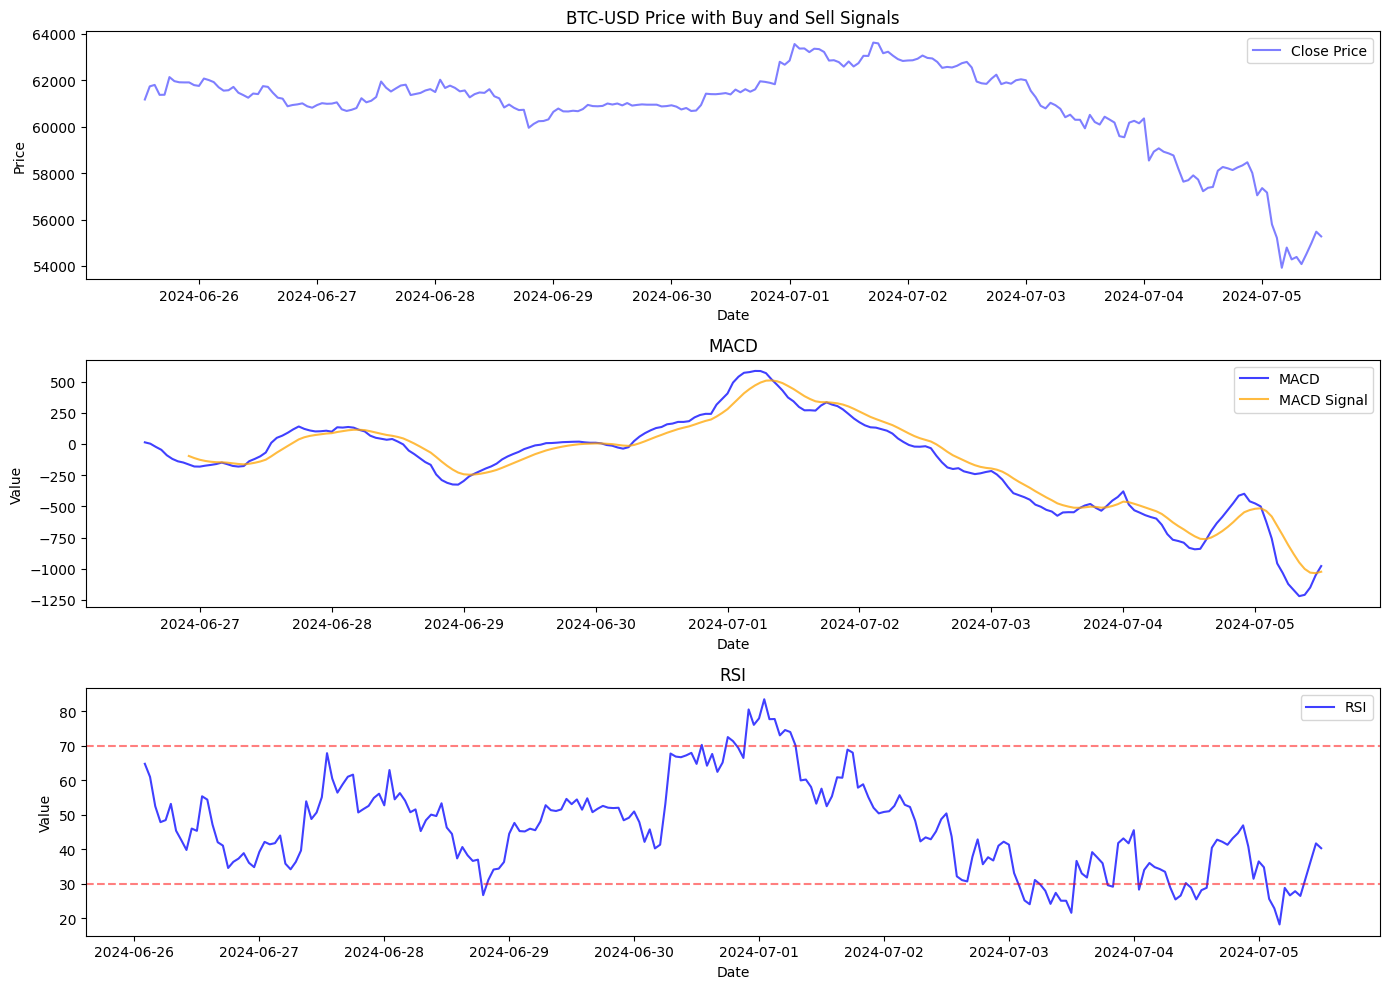

In [37]:
# Define the trading strategy: MACD and RSI
def apply_macd_rsi_strategy(df):
    # Calculate MACD
    macd = ta.trend.MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    
    # Calculate RSI
    rsi = ta.momentum.RSIIndicator(df['Close'])
    df['RSI'] = rsi.rsi()

    # Generate trading signals
    df['Signal'] = 0  # Default to no signal

    # Buy signal: MACD line crosses above signal line and RSI < 30
    df.loc[(df['MACD'] > df['MACD_Signal']) & (df['RSI'] < 30), 'Signal'] = 1

    # Sell signal: MACD line crosses below signal line and RSI > 70
    df.loc[(df['MACD'] < df['MACD_Signal']) & (df['RSI'] > 70), 'Signal'] = -1

    df['Position'] = df['Signal'].diff()  # Buy signal (1) or sell signal (-1)

    return df

# Apply the strategy to the data
df = apply_macd_rsi_strategy(df)

# Display the DataFrame with signals
print(df.tail())

# Plot the results
plt.figure(figsize=(14, 10))

# Plot price and signals
plt.subplot(3, 1, 1)
plt.plot(df['Close'], label='Close Price', color='blue', alpha=0.5)
buy_signals = df[df['Position'] == 1]
sell_signals = df[df['Position'] == -1]
if not buy_signals.empty:
    plt.scatter(buy_signals.index, buy_signals['Close'], label='Buy Signal', marker='^', color='green', s=100, lw=2, edgecolors='black')
if not sell_signals.empty:
    plt.scatter(sell_signals.index, sell_signals['Close'], label='Sell Signal', marker='v', color='red', s=100, lw=2, edgecolors='black')
plt.title('BTC-USD Price with Buy and Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Plot MACD and signals
plt.subplot(3, 1, 2)
plt.plot(df['MACD'], label='MACD', color='blue', alpha=0.75)
plt.plot(df['MACD_Signal'], label='MACD Signal', color='orange', alpha=0.75)
plt.title('MACD')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Plot RSI and signals
plt.subplot(3, 1, 3)
plt.plot(df['RSI'], label='RSI', color='blue', alpha=0.75)
plt.axhline(30, linestyle='--', alpha=0.5, color='red')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')
plt.title('RSI')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

## Technical Analysis

## Strategy

## Backtesting the strategy

In [23]:
#Create class instance 
#obj = MovingAvverageCrossStrategy(df, 10, 50)

#Call class method to create signals
#signals = obje.generate_signals(10)